## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

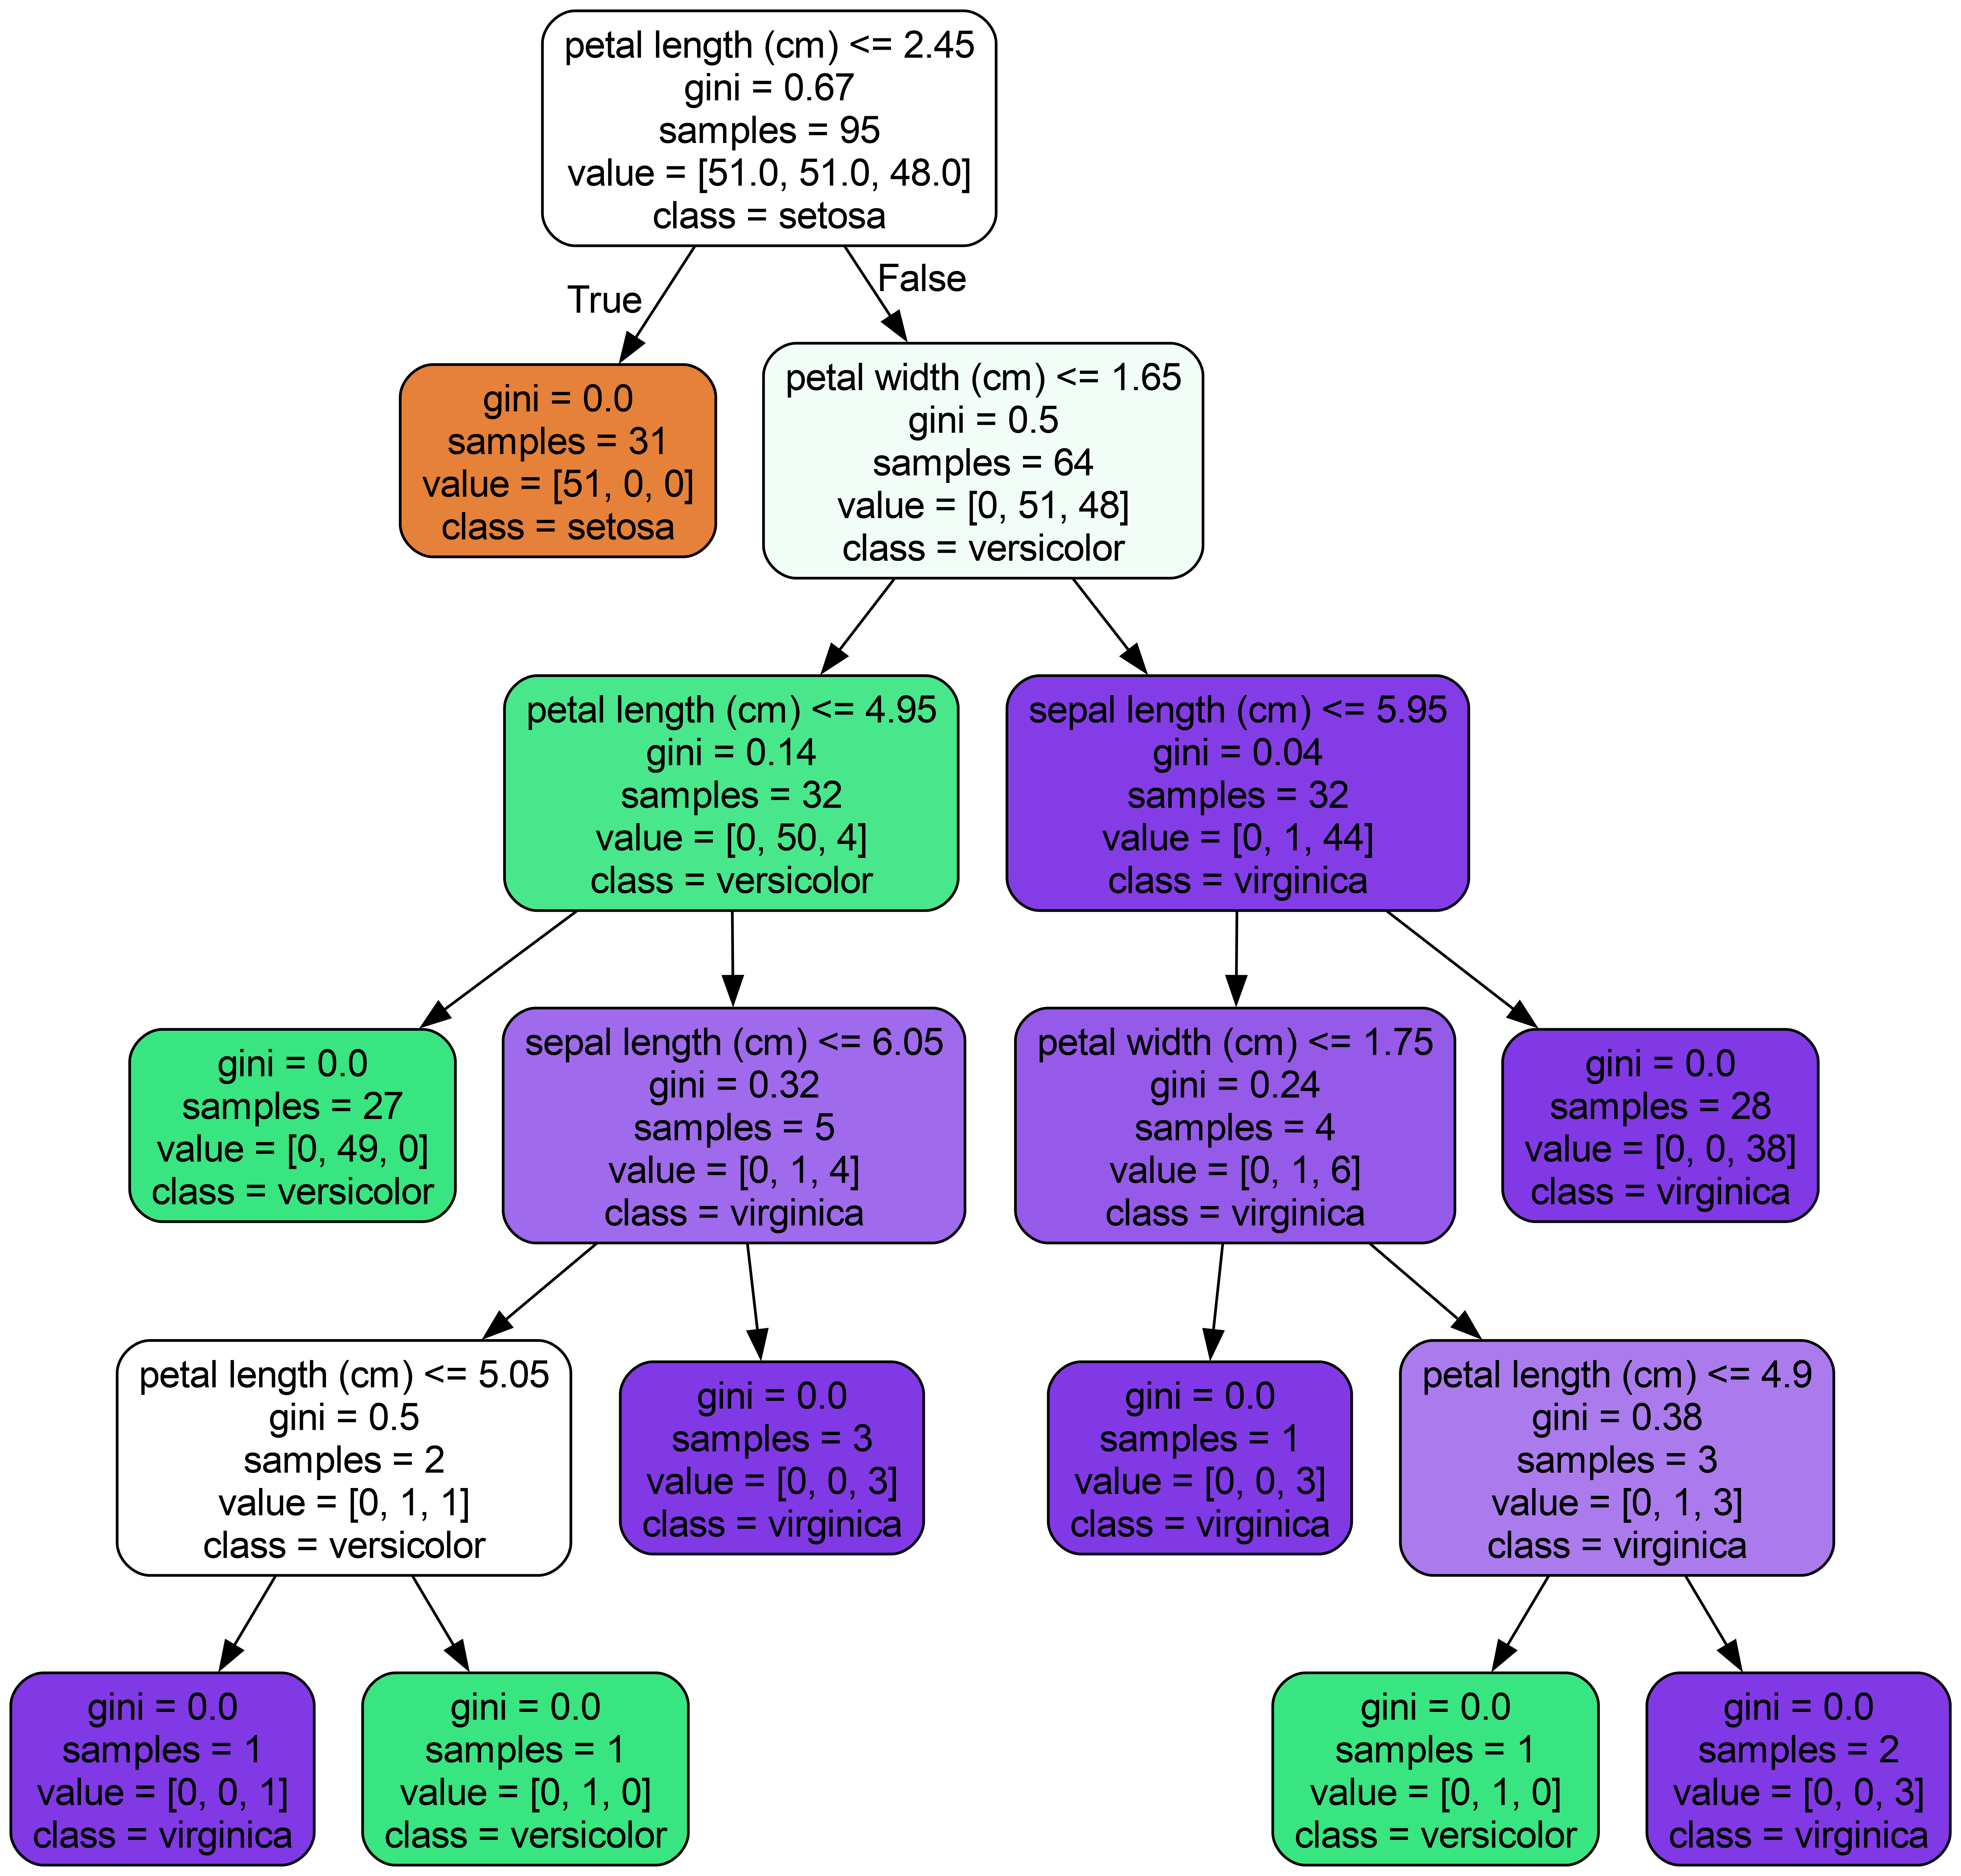

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [2]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [3]:
url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [4]:
df.disease.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2218 entries, 0 to 2217
Series name: disease
Non-Null Count  Dtype 
--------------  ----- 
19 non-null     object
dtypes: object(1)
memory usage: 17.5+ KB


In [5]:
df.shape

(2218, 18)

In [6]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [7]:
#counts of response variable values
df.state.value_counts()

state
isolated    1791
released     307
deceased      32
Name: count, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

<div style="color:#b68900"> 

I initially thought to use:

```python
df['n_age'] = (datetime.now().year - df.birth_year)
```
<br>

However, assuming the data reflect the state of things in 2020, it would probably be better to simply use `2020` instead of `datetime.now().year`.

</div>

In [8]:
df['n_age'] = 2020 - df.birth_year
df[['birth_year','n_age','age']]

,birth_year,n_age,age
0,1964.0,56.0,50s
1,1987.0,33.0,30s
2,1964.0,56.0,50s
3,1991.0,29.0,20s
4,1992.0,28.0,20s
...,...,...,...
2213,1990.0,30.0,30s
2214,1998.0,22.0,20s
2215,1998.0,22.0,20s
2216,1972.0,48.0,40s


<div style="color:#b68900"> 

Looks like `n_age` is in agreement with `age` at a quick glance.  Since `n_age` came from `birth_year` and is more precise than `age`, I will drop `age`.  Will keep `birth_year` for now.

</div>

In [9]:
df = df.drop(['age'],axis=1)
df.columns

Index(['patient_id', 'global_num', 'sex', 'birth_year', 'country', 'province',
       'city', 'disease', 'infection_case', 'infection_order', 'infected_by',
       'contact_number', 'symptom_onset_date', 'confirmed_date',
       'released_date', 'deceased_date', 'state', 'n_age'],
      dtype='object')

### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [10]:
df.isna().sum().sort_values(ascending=False)

disease               2199
deceased_date         2186
infection_order       2176
symptom_onset_date    2025
released_date         1995
contact_number        1807
infected_by           1749
infection_case        1055
global_num             904
n_age                  454
birth_year             454
sex                    145
confirmed_date         141
state                   88
city                    65
province                 0
country                  0
patient_id               0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   country             2218 non-null   object 
 5   province            2218 non-null   object 
 6   city                2153 non-null   object 
 7   disease             19 non-null     object 
 8   infection_case      1163 non-null   object 
 9   infection_order     42 non-null     float64
 10  infected_by         469 non-null    float64
 11  contact_number      411 non-null    float64
 12  symptom_onset_date  193 non-null    object 
 13  confirmed_date      2077 non-null   object 
 14  released_date       223 non-null    object 
 15  deceased_date       32 non-null     object 
 16  state 

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [12]:
df['disease'] = df['disease'].fillna('0').astype(int)
df.disease.unique()

array([0, 1])

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [13]:
df.select_dtypes('number').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_id       2218 non-null   int64  
 1   global_num       1314 non-null   float64
 2   birth_year       1764 non-null   float64
 3   disease          2218 non-null   int64  
 4   infection_order  42 non-null     float64
 5   infected_by      469 non-null    float64
 6   contact_number   411 non-null    float64
 7   n_age            1764 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 138.8 KB


In [14]:
df.select_dtypes('float64').columns

Index(['global_num', 'birth_year', 'infection_order', 'infected_by',
       'contact_number', 'n_age'],
      dtype='object')

In [15]:
cols2avg = df.select_dtypes('float64').columns[:-1]

df[cols2avg].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   global_num       1314 non-null   float64
 1   birth_year       1764 non-null   float64
 2   infection_order  42 non-null     float64
 3   infected_by      469 non-null    float64
 4   contact_number   411 non-null    float64
dtypes: float64(5)
memory usage: 86.8 KB


In [16]:
df[cols2avg] = df[cols2avg].apply(lambda x : x.fillna(x.mean()))

In [17]:
df.isna().sum().sort_values()

patient_id               0
global_num               0
birth_year               0
country                  0
province                 0
disease                  0
infection_order          0
infected_by              0
contact_number           0
city                    65
state                   88
confirmed_date         141
sex                    145
n_age                  454
infection_case        1055
released_date         1995
symptom_onset_date    2025
deceased_date         2186
dtype: int64

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [18]:
# Since we just imputed birth_year, we should update n_age to reflect that...
df.n_age = (2020 - df['birth_year'])
df.n_age.isna().sum()

0

In [19]:
def nullcounts(df):
    indices=[]
    values=[]
    for col in df.columns:
        if df[col].isna().sum():
            indices.append(col)
            values.append(int(df[col].isna().sum()))
    return pd.DataFrame({'count':values},index=indices).sort_values('count',ascending=False)

nullcounts(df)

,count
deceased_date,2186
symptom_onset_date,2025
released_date,1995
infection_case,1055
sex,145
confirmed_date,141
state,88
city,65


<div style="color:#b68900"> 
    
Given the `state` is the target feature, entries with null for this feature essentially provide no training info for the model.  Will want to separate these from the rest, and perhaps try to predict the missing `state` values after modeling (i.e., that's basically the "imputation" method - to build the model and predict based on the rest). 

</div>



In [20]:
# DataFrame with null for state
no_state = df[df.state.isna()]
no_state.shape

(88, 18)

In [21]:
# DataFrame for modeling
df = df[~df.state.isna()]
df.shape

(2130, 18)

In [22]:
nullcounts(df)

,count
deceased_date,2098
symptom_onset_date,1943
released_date,1907
infection_case,1054
sex,145
confirmed_date,141
city,65


<div style="color:#b68900"> 

**Plan for Imputation**


<u> Date Variables </u>
+ Note that the target feature `status` has unique values *isolated*, *released*, and *deceased*. 
    + Again considering this from the perspective of 2020, those who reported having symptoms (i.e., non-null for `symptom_onset_date`) and those who tested positive (i.e., non-null for `confirmed_date`) would have been isolated, which essentially gives away the `status`.
    + Similarly, a non-null `deceased_date` implies the `status` is *deceased*, while non-null for `release_date` implies `status` is *released*
    + Looking ahead, it seems like the plan is to drop these columns anyways, so will hold off on imputation here.

<u> Other Variables w/ Null </u>
+ Imputing `infection_case` :   

In [23]:
df['infection_case'].value_counts()

infection_case
contact with patient                459
etc                                 215
Guro-gu Call Center                 102
Shincheonji Church                   86
overseas inflow                      51
Onchun Church                        33
gym facility in Cheonan              29
Ministry of Oceans and Fisheries     27
Cheongdo Daenam Hospital             21
Dongan Church                        17
Eunpyeong St. Mary's Hospital        14
Seongdong-gu APT                     13
gym facility in Sejong                4
Suyeong-gu Kindergarten               3
River of Grace Community Church       1
Pilgrimage to Israel                  1
Name: count, dtype: int64

<div style="color:#b68900"> 

This appears to be the setting in which they must have gotten infected.  Perhaps an "Unknown" category would be best - i.e., the fact that you don't know who you got it from could potentially say a lot about the outcome.

</div>

In [24]:
df.loc[:,'infection_case'] = df['infection_case'].fillna('unknown')
print(df.infection_case.value_counts())

print('\n',df.infection_case.isna().sum())

infection_case
unknown                             1054
contact with patient                 459
etc                                  215
Guro-gu Call Center                  102
Shincheonji Church                    86
overseas inflow                       51
Onchun Church                         33
gym facility in Cheonan               29
Ministry of Oceans and Fisheries      27
Cheongdo Daenam Hospital              21
Dongan Church                         17
Eunpyeong St. Mary's Hospital         14
Seongdong-gu APT                      13
gym facility in Sejong                 4
Suyeong-gu Kindergarten                3
River of Grace Community Church        1
Pilgrimage to Israel                   1
Name: count, dtype: int64

 0


<div style="color:#b68900"> 

+ Imputing `sex`:

In [25]:
df['sex'].value_counts()

sex
female    1119
male       866
Name: count, dtype: int64

<div style="color:#b68900"> 

The data are already roughly evenly split, with females being in the majority; with only 145 unreported sexes, perhaps mode imputation (replacing with "female") wouldn't change the overall very much.  Could alternatively make an "unreported" category, but it doesn't seem as useful since its such a small number of cases.

In [26]:
df.loc[:,'sex'] = df.sex.fillna(df['sex'].mode()[0])
print(df.sex.value_counts())
print('\n',df.sex.isna().sum())

sex
female    1264
male       866
Name: count, dtype: int64

 0


<div style="color:#b68900"> 

+ Imputing `city`:

Only 65 are null here, so mode imputation would probably not drastically alter the data - i.e., what is the most common city in the non-null; this would add 65 to 535 in Gyeongsan-si:


In [27]:
df.city.value_counts().head(1)

city
Gyeongsan-si    535
Name: count, dtype: int64

In [28]:
df.loc[:,'city'] = df.city.fillna(df['city'].mode()[0])
print(df.city.value_counts())
print('\n',df.city.isna().sum())

city
Gyeongsan-si       600
Cheonan-si          98
Bonghwa-gun         60
Gumi-si             59
Chilgok-gun         49
                  ... 
Danyang-gun          1
Jeungpyeong-gun      1
Taebaek-si           1
Samcheok-si          1
Guri-si              1
Name: count, Length: 133, dtype: int64

 0


 **<font color='teal'> Check for any remaining null values.</font>**

In [29]:
nullcounts(df)

,count
deceased_date,2098
symptom_onset_date,1943
released_date,1907
confirmed_date,141


Remove date columns from the data.


In [30]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

Review the count of unique values by column.

In [31]:
print(df.nunique())

patient_id         2130
global_num         1224
sex                   2
birth_year           97
country               4
province             17
city                133
disease               2
infection_case       17
infection_order       7
infected_by         196
contact_number       73
state                 3
n_age                97
dtype: int64


Review the percent of unique values by column.

In [32]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.574648
sex                0.000939
birth_year         0.045540
country            0.001878
province           0.007981
city               0.062441
disease            0.000939
infection_case     0.007981
infection_order    0.003286
infected_by        0.092019
contact_number     0.034272
state              0.001408
n_age              0.045540
dtype: float64


Review the range of values per column.

In [33]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2130.0,4.095989e+09,2.197921e+09,1.000000e+09,1.600000e+09,6.001000e+09,6.004000e+09,7.000000e+09
global_num,2130.0,4.526482e+03,2.137668e+03,1.000000e+00,4.051250e+03,4.664817e+03,5.445500e+03,8.717000e+03
birth_year,2130.0,1.974937e+03,1.728607e+01,1.916000e+03,1.965000e+03,1.974989e+03,1.988000e+03,2.020000e+03
disease,2130.0,8.920188e-03,9.404664e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infection_order,2130.0,2.285714e+00,1.741536e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,2130.0,2.620626e+09,7.269510e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2130.0,2.414551e+01,3.996888e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03
n_age,2130.0,4.506298e+01,1.728607e+01,0.000000e+00,3.200000e+01,4.501134e+01,5.500000e+01,1.040000e+02


### Check for duplicated rows

In [34]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


Print the categorical columns and their associated levels.

In [35]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,2
1,country,4
2,province,17
3,city,133
4,infection_case,17
5,state,3


**<font color='teal'> Plot the correlation heat map for the features.</font>**

In [36]:
df[['global_num','patient_id']].head(3)

,global_num,patient_id
0,2.0,1000000001
1,5.0,1000000002
2,6.0,1000000003


In [37]:
df[['global_num','patient_id']].tail(3)

,global_num,patient_id
2215,222.0,7000000002
2216,4345.0,7000000003
2217,5534.0,7000000004


<div style="color:#b68900"> 
<u> Some Column Considerations </u>
    
+ Noting that `global_num`, `patient_id`, and `infected_by` seem to be identifiers, I will keep them out of such correlational EDA.
+ `birth_year` is directly correlated with `n_age`, since we generated the former from the latter - so will just keep `birth_year` out of it as well.
</div>

In [38]:
droptemp = ['global_num','patient_id','infected_by','birth_year']
dfd = df.drop(droptemp,axis=1)
dfd.head()

,sex,country,province,city,disease,infection_case,infection_order,contact_number,state,n_age
0,male,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,75.0,released,56.0
1,male,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,31.0,released,33.0
2,male,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,17.0,released,56.0
3,male,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,9.0,released,29.0
4,female,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,2.0,released,28.0


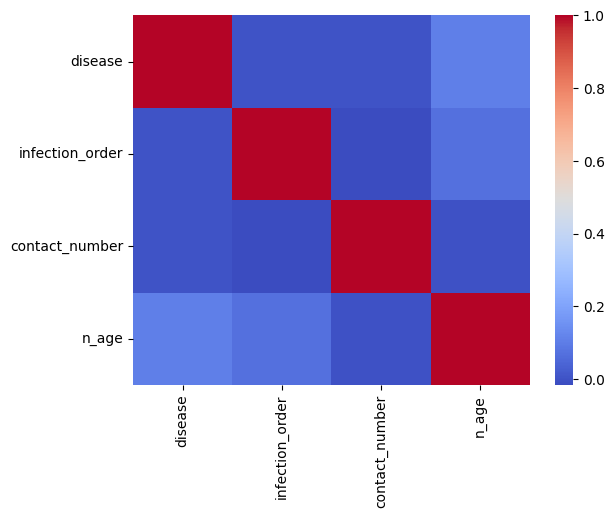

In [39]:
sns.heatmap(dfd.select_dtypes('number').corr(), cmap='coolwarm');plt.show()

<div style="color:#b68900"> 

Some slight positive correlations of `n_age` with `disease` and `infection_order`.  Given `disease=1` is fairly rare (19 cases), this might represent COVID-19 with severe disease, in which case would make sense to correlate with older age / weaker immune system on average.  


The `infection_order`, as this explained in the [comments](https://www.kaggle.com/code/kimjihoo/ds4c-what-is-this-dataset-detailed-description/comments) section by the author Kimjihoo (username **data artist**):    

</div>

> 'infection order = 1' means infection was from Wuhan.
> 
> 'infection order = 2' means infection was from the one whose infection order is 1.
> 
> 'infection order = n' means infection was from the one whose infection order is n-1.
> 
> Null values mean that we cannot check the infection order.

<div style="color:#b68900"> 

The very slight correlation with age might represent that the majority of eldery people in Korea getting infected will likely not be traveling as much as younger people, and therefore are unlikely to directly get the infection directly from Wuhan. 

</div>



**<font color='teal'> Plot the boxplots to check for outliers. </font>**

In [40]:
dfd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2130 entries, 0 to 2217
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sex              2130 non-null   object 
 1   country          2130 non-null   object 
 2   province         2130 non-null   object 
 3   city             2130 non-null   object 
 4   disease          2130 non-null   int64  
 5   infection_case   2130 non-null   object 
 6   infection_order  2130 non-null   float64
 7   contact_number   2130 non-null   float64
 8   state            2130 non-null   object 
 9   n_age            2130 non-null   float64
dtypes: float64(3), int64(1), object(6)
memory usage: 183.0+ KB


<div style="color:#b68900"> 

Doesn't seem like boxplot could show much for categorical variables, along with the `disease` feature&mdash;although this is an `int`, it practically is a boolean given it's only 1s and 0s.  This leaves the following features for boxplots:

</div>

In [41]:
bxcols = dfd.select_dtypes('number').drop('disease',axis=1).columns
for i,c in enumerate(bxcols):
    print(str(i+1)+". ", c)

1.  infection_order
2.  contact_number
3.  n_age


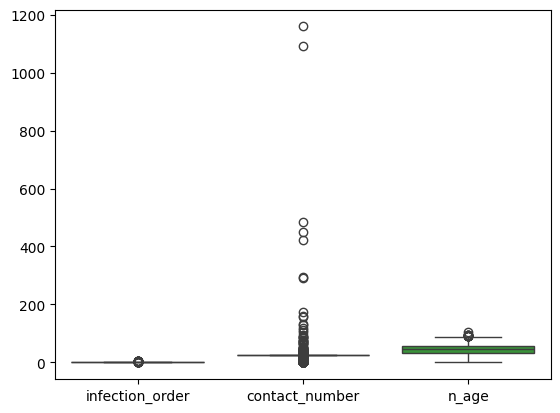

In [42]:
sns.boxplot(data=df[bxcols]); plt.show()

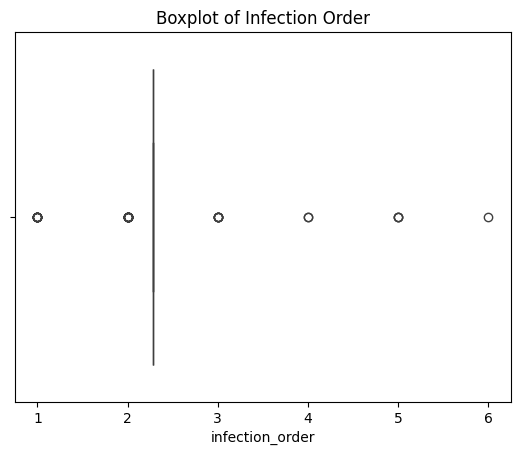

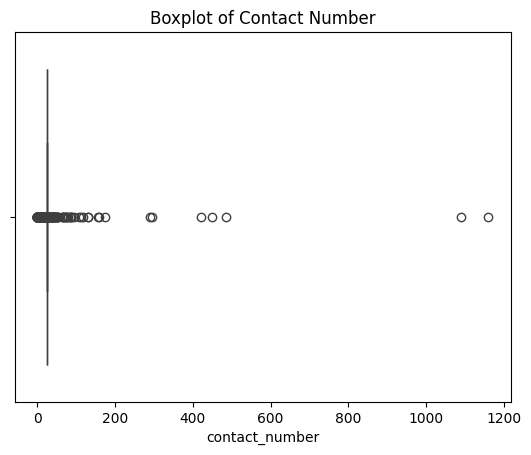

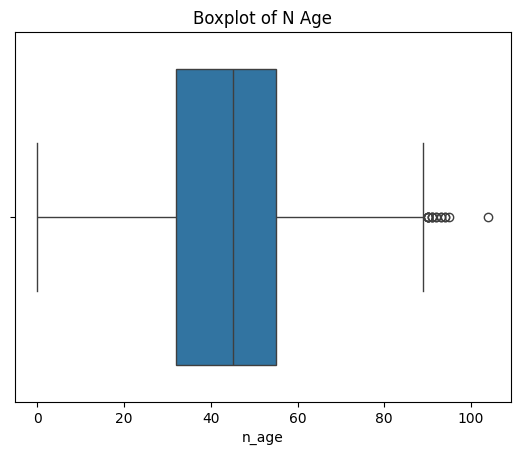

In [43]:
for col in bxcols:
    sns.boxplot(data=df,x=col)
    plt.title(f'Boxplot of {col.title().replace('_',' ')}')
    plt.show()

<div style="color:#b68900"> 
Although there are outliers, they generally all seem plausible with no obvious point of removing them.  For example, there are certainly a few ages well above 90 years old, but this is a true representation of the ages of infected individuals in Korea at the time.  The `contact_number` would similarly have very extreme outliers given how certain lifestyles/professions can in rare cases exposes an individual to 100s or 1000s of contacts (e.g., tourguides, journalists, flight attendants, retail workers - especially in a busy/crowded city).

**<font color='teal'> Create dummy features for object type features. </font>**

In [44]:
X = pd.get_dummies(dfd.drop('state',axis=1)); X

,disease,infection_order,contact_number,n_age,sex_female,sex_male,country_China,country_Korea,country_Mongolia,country_Thailand,...,infection_case_River of Grace Community Church,infection_case_Seongdong-gu APT,infection_case_Shincheonji Church,infection_case_Suyeong-gu Kindergarten,infection_case_contact with patient,infection_case_etc,infection_case_gym facility in Cheonan,infection_case_gym facility in Sejong,infection_case_overseas inflow,infection_case_unknown
0,0,1.000000,75.000000,56.0,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
1,0,1.000000,31.000000,33.0,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
2,0,2.000000,17.000000,56.0,False,True,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False
3,0,1.000000,9.000000,29.0,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
4,0,2.000000,2.000000,28.0,True,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212,0,2.285714,24.128954,49.0,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
2214,0,2.285714,87.000000,22.0,False,True,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
2215,0,2.285714,84.000000,22.0,True,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
2216,0,2.285714,21.000000,48.0,True,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False


In [45]:
y = df.state; y

0       released
1       released
2       released
3       released
4       released
          ...   
2212    isolated
2214    isolated
2215    released
2216    released
2217    isolated
Name: state, Length: 2130, dtype: object

### Split the data into test and train subsamples

In [46]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [47]:
ttset = [X_train, X_test, y_train, y_test]
for s in ttset:
    print(s.shape)

(1704, 177)
(426, 177)
(1704,)
(426,)


### Scale data to prep for model creation

In [48]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [49]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [50]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.854
Random Forest: f1-score=0.838


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [51]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[  5   2   0]
 [  0 346  19]
 [  0  41  13]]
Normalized confusion matrix
[[0.71 0.29 0.  ]
 [0.   0.95 0.05]
 [0.   0.76 0.24]]


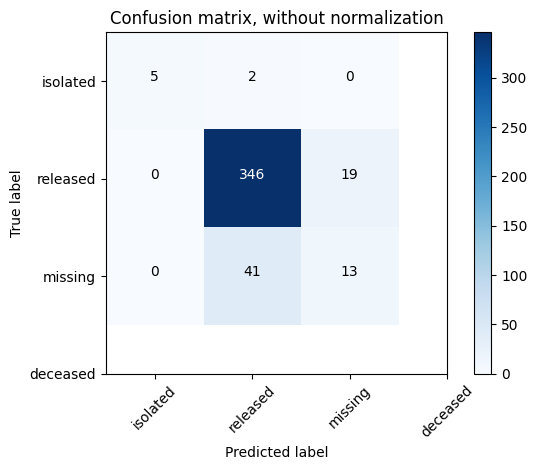

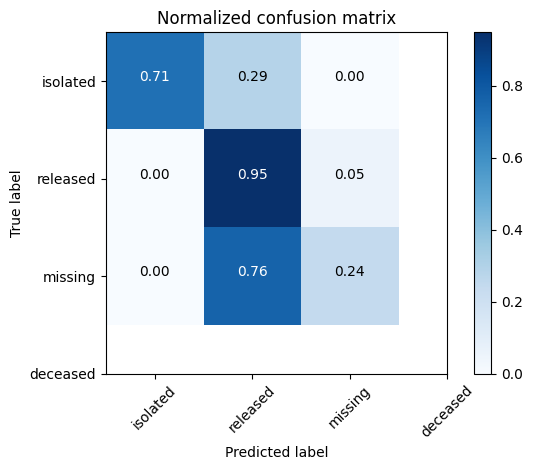

In [52]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


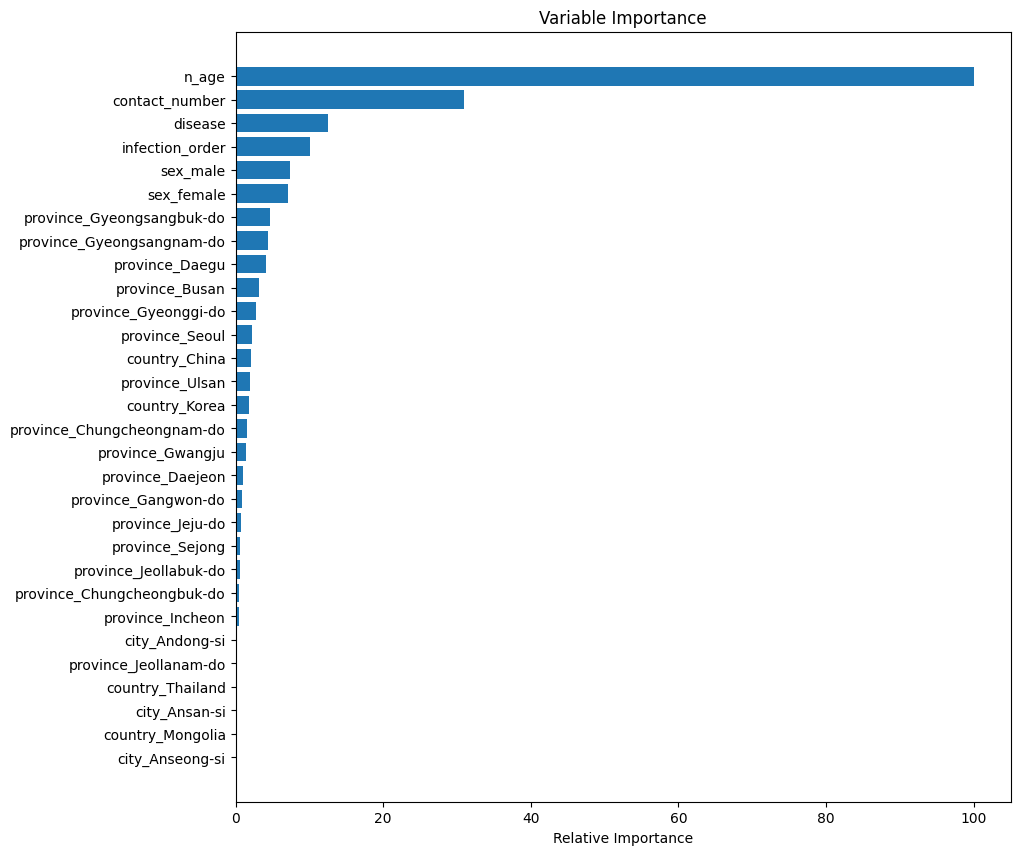

In [53]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.